In [83]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import cv2 # OpenCV
import pytesseract  # pip install pytesseract
import numpy as np
import re

In [84]:

class ProcessImage():

    lang = 'por'
    psm = None
    min_conf = 40   # confiança mínima
    font_dir = '../recursos/Fontes/calibri.ttf'
    data_regex = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'
    
    def __init__(self, lang='por', psm=None, min_conf=40):
        self.lang = lang
        self.min_conf = min_conf
        self.psm = psm
    
    def draw_square(self, resultado, indice, img, cor = (255, 100, 0)):
        """ Faz o desenho do retanmgulo na imagem """
        x = resultado['left'][indice]
        y = resultado['top'][indice]
        w = resultado['width'][indice]
        h = resultado['height'][indice]
        cv2.rectangle(img, (x, y), (x + w, y + h), cor, 2)
        return x, y, img

    def draw_text(self, texto, x, y, img, fonte, tamanho_texto=32, fill=(255, 0, 0, 0)):
        """ Faz o desenho do texto na imagem """
        font = ImageFont.truetype(fonte, tamanho_texto)
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((x, y), texto, font=font, fill=fill)
        return np.array(img_pil)

    def write_overlays_in_image(self, resultado, img, min_conf):
        """ Scaneia os textos encontrados na imagem e suas posições, cria uma caixa e desenha na imagem
        Coloca as datas em vermelho
        """
        self.datas = []
        self.texts = []
        img_copia = img.copy()
        for i in range(0, len(resultado['text'])):
            confianca = int(resultado['conf'][i])
            if confianca > min_conf:
                texto = resultado['text'][i]
                if not texto.isspace() and len(texto) > 0:
                    fill = (255, 0, 0, 0)       
                    if re.match(self.data_regex, texto):
                        fill =  (0,0,255)
                        self.datas.append(texto)
                    else:
                        self.texts.append(texto)
                    
                    x, y, img = self.draw_square(resultado, i, img_copia, fill)
                    img_copia = self.draw_text(texto, x, y - 10, img_copia, self.font_dir, 12, fill)
                
        return img_copia
    
    def scan(self, path):
        """ Faz o Scan na Imagem """
        image = self.open_image(path)
        resultado = self.detect_text_in_image(image)
        return self.write_overlays_in_image(resultado, image, self.min_conf)
    
    def display_image(self, image):
        """ Exibe a Imagem """
        display(Image.fromarray(image))
    
    def open_image(self, path):
        """ Abre o arquivo da Imagem e converte para o RGB """
        image = cv2.imread(path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image_rgb

    def detect_text_in_image(self, image_rgb):
        """ Detecta os textos na imagem """
        gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
        adapt_media = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
        
        invert = 255 - adapt_media
        self.display_image(invert)
        
        psm = ''
        if self.psm:
            psm = f'--psm {self.psm}'
        config_tesseract = f'--tessdata-dir tessdata {psm}'
        resultado = pytesseract.image_to_data(invert, config=config_tesseract, lang=self.lang, output_type=pytesseract.Output.DICT)
        return resultado



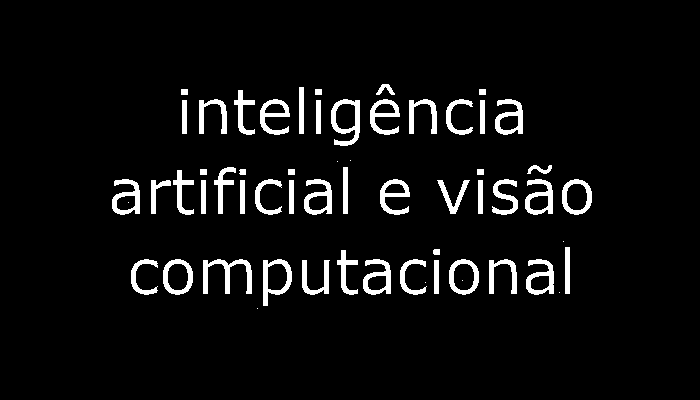

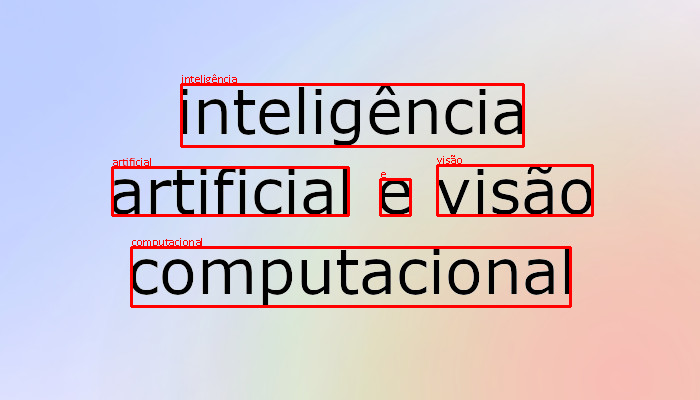

['inteligência', 'artificial', 'e', 'visão', 'computacional']


In [85]:
overlaw = ProcessImage()
image = overlaw.scan('../recursos/images/teste02.jpg')
overlaw.display_image(image)
print(overlaw.texts)

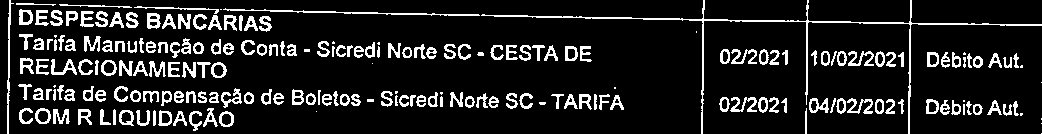

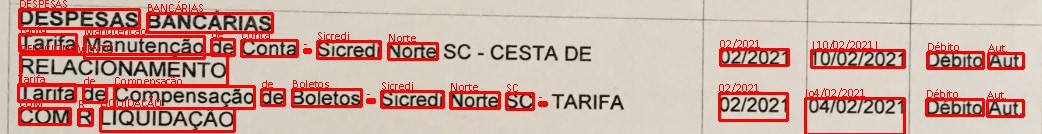

[]
['DESPESAS', 'BANCÁRIAS', 'Tarifa', 'Manutenção', 'de', 'Conta', '-', 'Sicredi', 'Norte', '02/2021', '|10/02/2021|', 'Débito', 'Aut.', 'RELACIONAMENTO', 'Tarifa', 'de', 'Compensação', 'de', 'Boletos', '-', 'Sicredi', 'Norte', 'SC', '-', '02/2021', 'Io4/02/2021', 'Débito', 'Aut.', 'COM', 'R', 'LIQUIDAÇÃO']


In [86]:
overlaw = ProcessImage()
image = overlaw.scan('../recursos/images/tabela_teste.jpg')
overlaw.display_image(image)
print(overlaw.datas)
print(overlaw.texts)

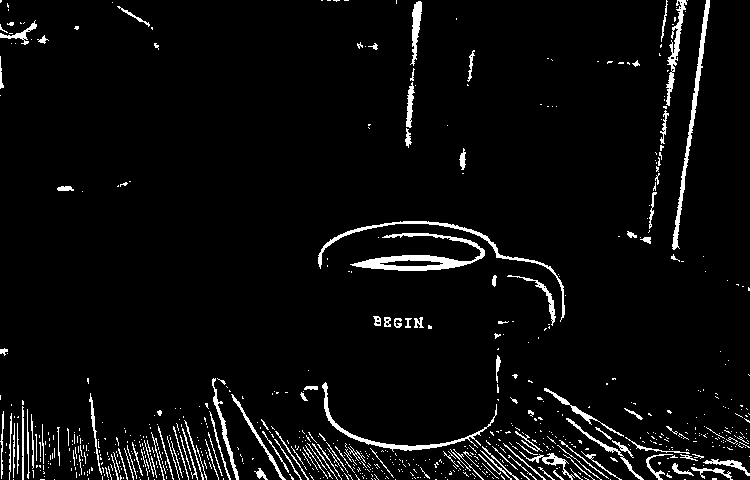

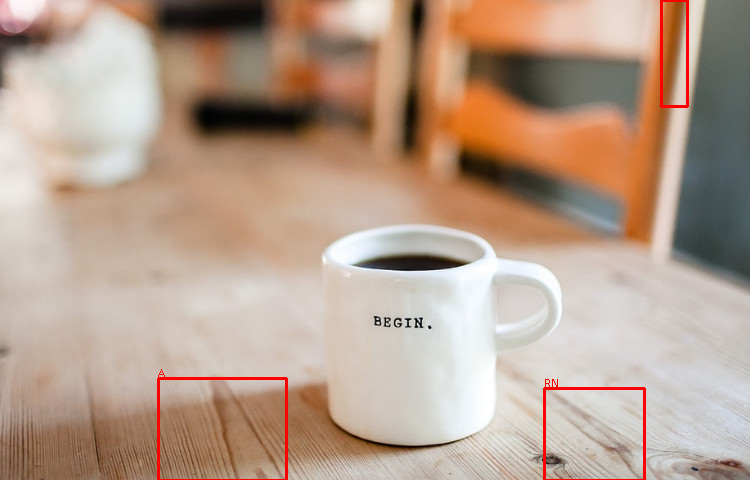

['7', 'A', 'RN']


In [87]:
overlaw = ProcessImage(lang = 'eng', psm = 11)
image = overlaw.scan('../recursos/images/caneca.jpg')
overlaw.display_image(image)
print(overlaw.texts)